<a href="https://colab.research.google.com/github/AfifaMasood/AfifaMasood/blob/main/Shoplifting_Project_1st_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the path to the FYP Dataset folder
dataset_path = '/content/drive/My Drive/FYP Dataset'

# Step 3: List all video files in the folder and its subfolders
import os

# Check if the folder exists
if os.path.exists(dataset_path):
    print("Dataset folder found!")
    # Walk through the folder recursively and collect video files
    video_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                video_files.append(os.path.join(root, file))
    print(f"Found {len(video_files)} video files:")
    for video in video_files:
        print(video)
else:
    print("Dataset folder not found! Check the path.")


Mounted at /content/drive
Dataset folder found!
Found 263 video files:
/content/drive/My Drive/FYP Dataset/Normal/Normal-6.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-3.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-7.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-10.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-5.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-4.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-2.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-9.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-11.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-1.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-12.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-21.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-14.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-13.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-16.mp4
/content/drive/My Drive/FYP Dataset/Normal/Normal-20.mp4
/content/drive/My Drive/F

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from keras.layers import *
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import os
import cv2
import shutil

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
dim = 256

IMAGE_HEIGHT = dim
IMAGE_WIDTH = dim

# Specify the number of frames that will be fed to the Neural Network
SEQUENCE_LENGTH = 60
CLASSES_LIST = ["0","1"]

In [ ]:
def frame_extraction(video_path):

    frame_list = []

    video_capture = cv2.VideoCapture(video_path)
    video_frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frame_window = max(int(video_frame_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        # set the current frame position of the video
        video_capture.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frame_window)

        success,frame = video_capture.read()

        # check if the frame is successfully setup or not
        if not success:
            break

        # Resize the frame into fixed size height and width
        resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))

        # Normalise the given frame
        normalized_frame = resized_frame/255

        # Append the normalised frame into  frame list
        frame_list.append(normalized_frame)

        # release the video capture object,
    video_capture.release()

    return frame_list

In [ ]:
def create_dataset():
    """
    Create features and labels from the dataset organized in subfolders.
    """
    dataset_path = '/content/drive/My Drive/FYP Dataset'
    features = []
    labels = []
    video_file_paths = []

    # List subfolders in the dataset directory
    subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

    # Process each subfolder
    for label_index, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(dataset_path, subfolder)
        video_files = [f for f in os.listdir(subfolder_path) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

        for video_file in video_files:
            video_path = os.path.join(subfolder_path, video_file)
            frames = frame_extraction(video_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(label_index)  # Assign label based on subfolder index
                video_file_paths.append(video_path)

    # Convert to NumPy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_file_paths

In [ ]:
# create a dataset
features, labels, video_file_paths = create_dataset()

In [ ]:
one_hot_encoded_labels = to_categorical(labels)

print("Shape of features:", features.shape)  # (num_samples, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, num_channels)
print("Shape of one-hot encoded labels:", one_hot_encoded_labels.shape)  # (num_samples, num_classes)

Shape of features: (261, 60, 256, 256, 3)
Shape of one-hot encoded labels: (261, 2)


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming features and one_hot_encoded_labels have been prepared
x_train, x_test, y_train, y_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size=0.25,
    shuffle=True,
    random_state=seed_constant
)

print("Training feature shape:", x_train.shape)  # Shape of training data
print("Testing feature shape:", x_test.shape)      # Shape of testing data
print("Training label shape:", y_train.shape)      # Shape of training labels
print("Testing label shape:", y_test.shape)        # Shape of testing labels

Training feature shape: (195, 60, 256, 256, 3)
Testing feature shape: (66, 60, 256, 256, 3)
Training label shape: (195, 2)
Testing label shape: (66, 2)


In [ ]:
# Creating Neural Network

input_layer = Input(shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3))

convlstm_1 = ConvLSTM2D(filters=4,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(input_layer)
pool1 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_1)
timedistributed_1 = TimeDistributed(Dropout(0.2))(pool1)

convlstm_2 = ConvLSTM2D(filters=8,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_1)
pool2 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_2)
timedistributed_2 = TimeDistributed(Dropout(0.2))(pool2)

convlstm_3 = ConvLSTM2D(filters=16,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_2)
pool3 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_3)
timedistributed_3 = TimeDistributed(Dropout(0.2))(pool3)

convlstm_4 = ConvLSTM2D(filters=32,kernel_size=(3,3),activation='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences=True)(timedistributed_3)
pool4 = MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last')(convlstm_4)

flatten = Flatten()(pool4)

output = Dense(units=len(CLASSES_LIST), activation='sigmoid')(flatten)



model = Model(input_layer,output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 256, 256, 3   0         
                             )]                                  
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 60, 254, 254, 4)   1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 60, 127, 127, 4)   0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 60, 127, 127, 4)   0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 60, 125, 125, 8)   3488      
                                                             

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs=3,batch_size=4,shuffle=True, validation_split=0.2,callbacks=[early_stopping_callback])

Epoch 1/3
39/39 [==============================] - 2655s 67s/step - loss: 0.8050 - accuracy: 0.6154 - val_loss: 0.9486 - val_accuracy: 0.4103
Epoch 2/3
39/39 [==============================] - 2576s 66s/step - loss: 0.6825 - accuracy: 0.5897 - val_loss: 0.6061 - val_accuracy: 0.6154
Epoch 3/3
39/39 [==============================] - 2553s 66s/step - loss: 0.5571 - accuracy: 0.6987 - val_loss: 0.5763 - val_accuracy: 0.6923


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)

print("Loss : ",loss)
print("Accuracy : ",accuracy)

3/3 [==============================] - 223s 57s/step - loss: 0.6256 - accuracy: 0.6212
Loss :  0.6255756616592407
Accuracy :  0.6212121248245239


In [ ]:
# Plotting loss curve for training and validation set

def plot_curve(model_training_history,metric_name_1,metric_name_2,plot_name):

    metric1 = model_training_history.history[metric_name_1]
    metric2 = model_training_history.history[metric_name_2]
    plt.plot(metric1,color='blue',label=metric_name_1)
    plt.plot(metric2,color='red',label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()
    plt.show()

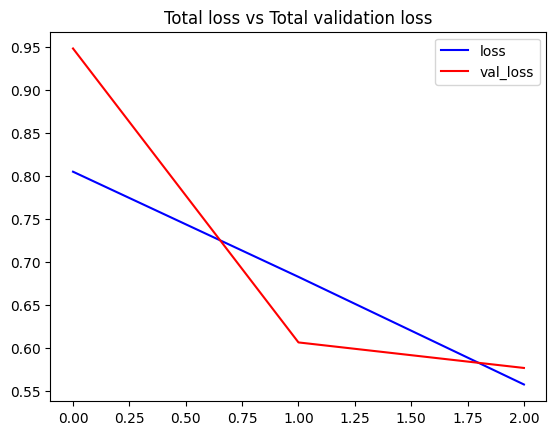

In [ ]:
plot_curve(history,'loss','val_loss',"Total loss vs Total validation loss")

In [ ]:
predictions = model.predict(x_test)

# Assuming predictions are in probability form and you need to convert them to binary labels
binary_predictions = (predictions > 0.5).astype('int32')

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, binary_predictions, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

3/3 [==============================] - 234s 58s/step
Precision: [0.73684211 0.57446809]
Recall: [0.41176471 0.84375   ]
F1 Score: [0.52830189 0.6835443 ]


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # Assuming test_Y is one-hot encoded
conf_matrix = confusion_matrix(true_labels, predicted_labels)

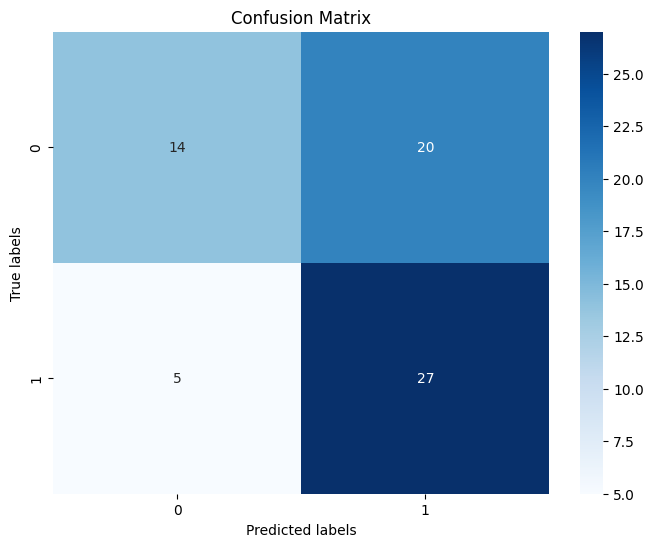

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("60_model_bs_256.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Save the model
model_path = '/content/drive/My Drive/60_model_bs_256'
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/60_model_bs_256


In [ ]:
# Save the model in .h5 format
model_path = '/content/drive/My Drive/60_model_bs_256ok.h5'
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/60_model_bs_256ok.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
